In [1]:
# lib
import sys

sys.path.append("..")

# set cwd one up
import os

os.chdir("..")
path = "data/hes/Hes1_example.csv"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
import gpflow

print(gpflow.config.default_positive_bijector())
print(gpflow.config.default_positive_minimum())
# gpflow.config.set_default_positive_bijector("exp")
# print(gpflow.config.default_positive_bijector())

softplus
0.0


In [3]:
from gpcell import OscillatorDetector
from gpcell.backend.priors import (
    sd_ou_priors,
    sd_ouosc_priors,
)

In [4]:
params = {
    "plots": ["MCMC", "MCMC_marginal"],
    "verbose": True,
    "joblib": True,
    "ou_prior_gen": sd_ou_priors,
    "ouosc_prior_gen": sd_ouosc_priors,
}
od: OscillatorDetector = OscillatorDetector.from_file(
    path, "Time (h)", "Background", "Cell", params
)
od.fit(methods="MCMC")



Starting Oscillator Detector...

Overriding default value for verbose
Overriding default value for plots
Overriding default value for joblib
Overriding default value for ou_prior_gen
Overriding default value for ouosc_prior_gen

Loaded data with 12 cells and 4 background noise models
Plots: on

Fitting background noise...
Background noise results:
Standard deviation: 7.302221575486058

Fitting MCMC...

Small, non-homogenous traces: 12 cells


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  12 out of  12 | elapsed: 22.2min finished


Unconstrained 1 r_hat: 2.281118513476471, ess: 3.964355285279568
Unconstrained 2 r_hat: 1.2913927840945774, ess: 27.141872768524625
Unconstrained 3 r_hat: 1.7295976109241904, ess: 4.665131564840377
Unconstrained 4 r_hat: 1.5039883748335334, ess: 5.637371004339189
Unconstrained 5 r_hat: 1.7142334733290574, ess: 4.699894486442454
Unconstrained 6 r_hat: 2.185542665835758, ess: 3.871565700016538
Unconstrained 7 r_hat: 1.665374458725636, ess: 5.109943564050509
Unconstrained 8 r_hat: 1.004588168812571, ess: 366.97959528191194
Unconstrained 9 r_hat: 1.7459007529237587, ess: 4.748232273500001
Unconstrained 10 r_hat: 1.7034171137299405, ess: 4.838009386038884
Unconstrained 11 r_hat: 1.9482016059324077, ess: 4.356517982437553
Unconstrained 12 r_hat: 1.0332009402768065, ess: 123.37202388177836
Shape of beta samples: (3000,)
Cell 1 prior mass: 0.05823546641575129, posterior mass: 0.6666666666666666
Cell 2 prior mass: 0.05823546641575129, posterior mass: 1.0
Cell 3 prior mass: 0.05823546641575129, 

/Users/tsd/Python/GPCell/gpcell/main.py:986: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


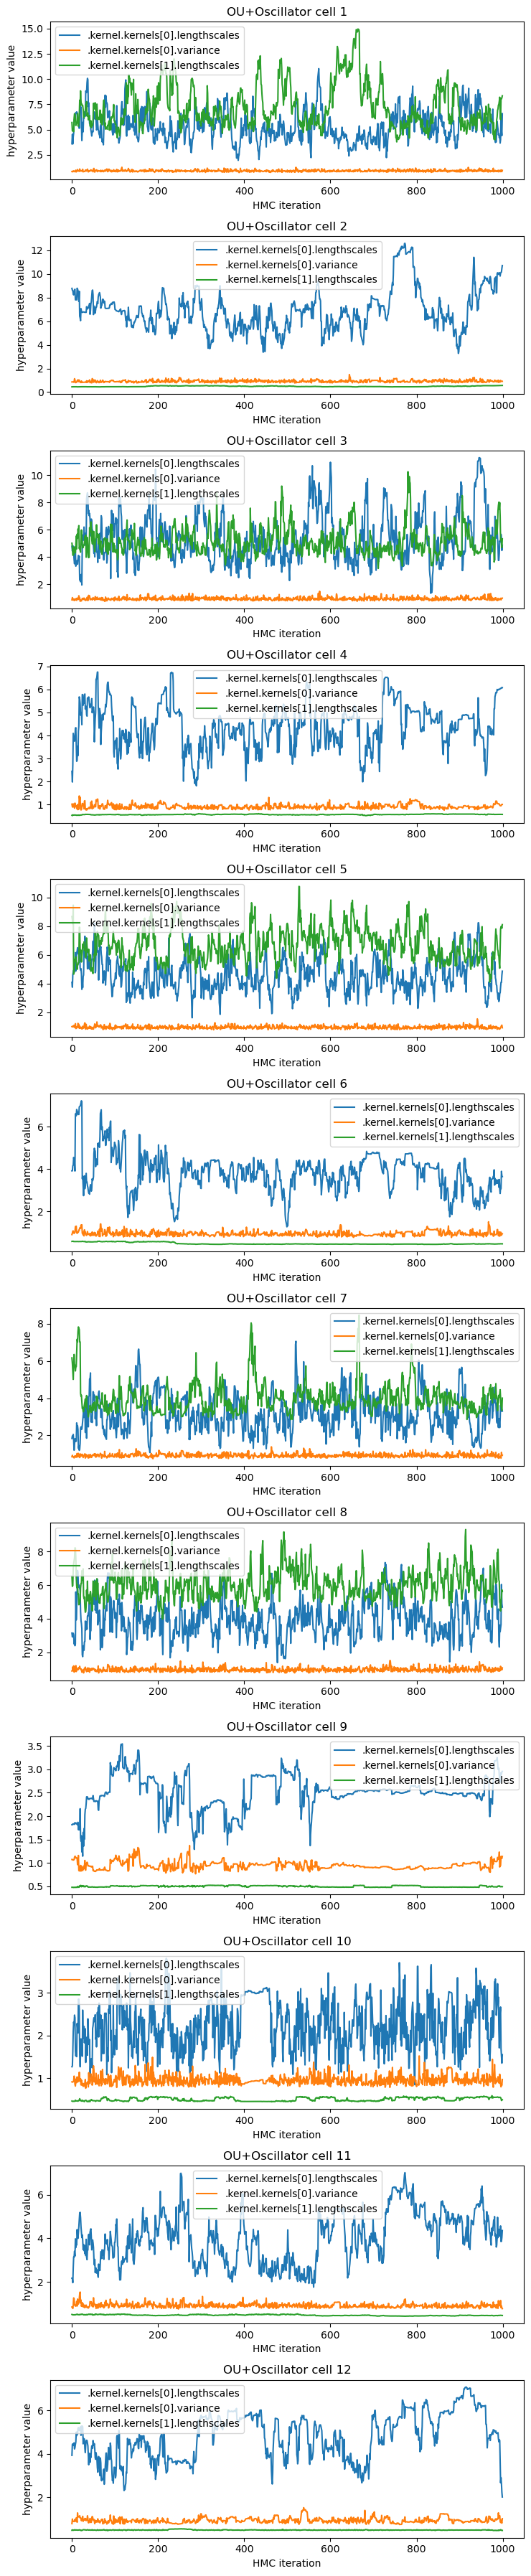

In [5]:
od.mcmc_plot

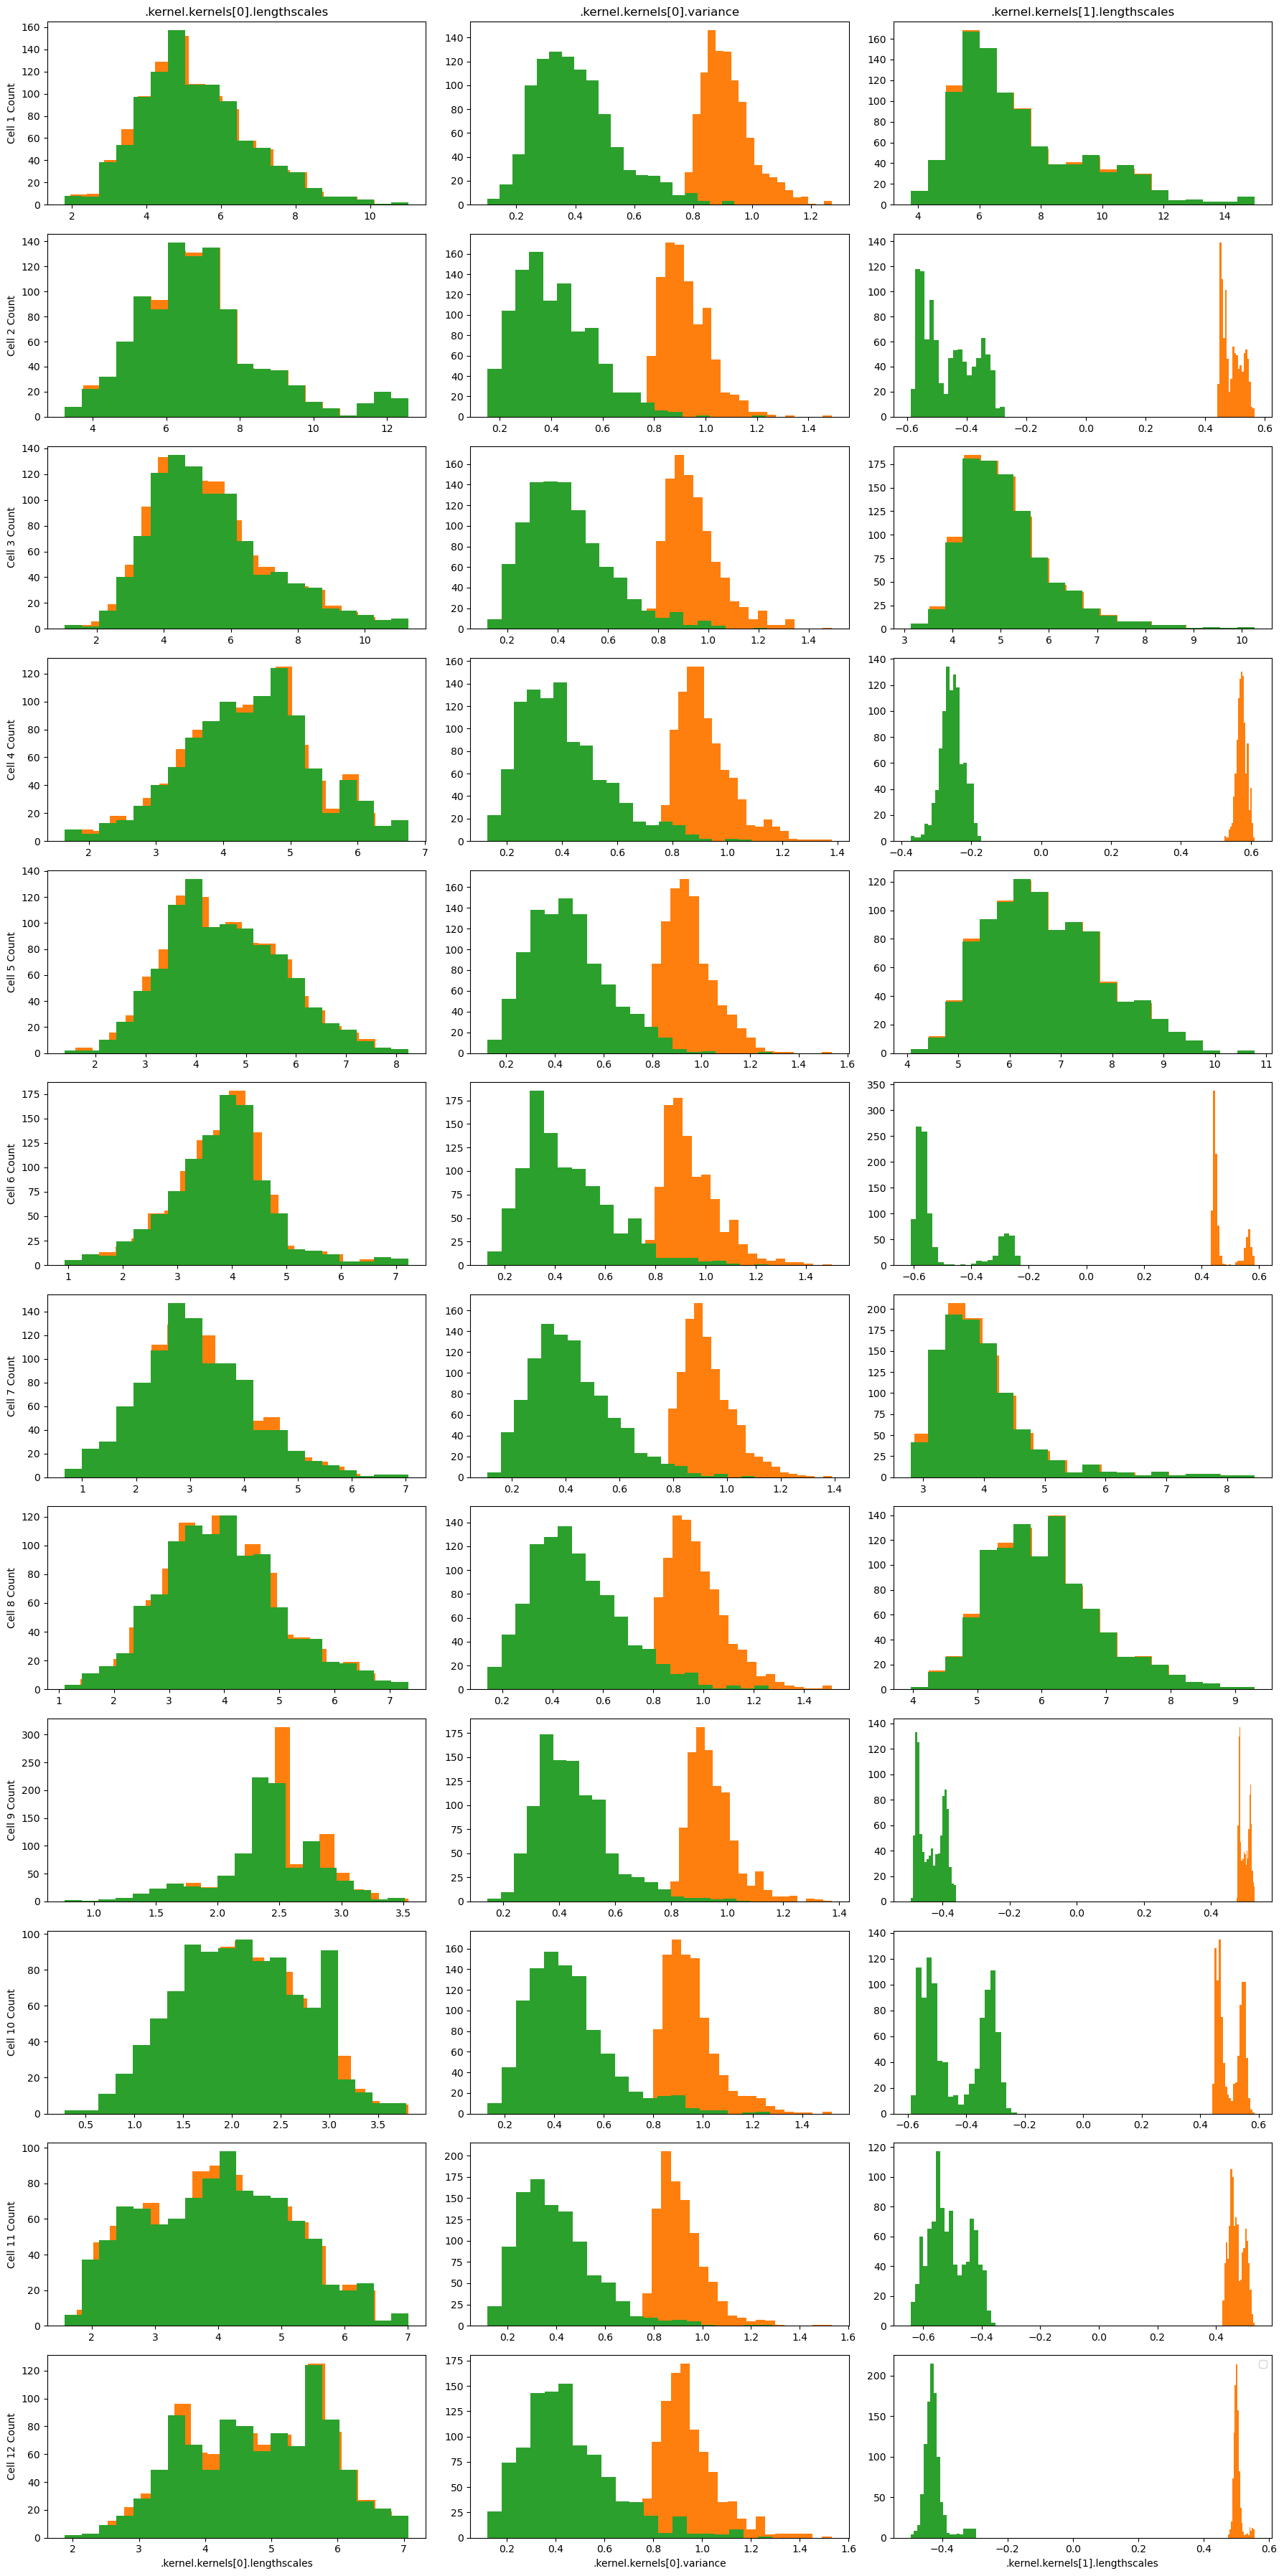

In [6]:
od.marginal_plot

# MCMC Dev

In [ ]:
# Standard Library Imports
from typing import Sequence

# Third-Party Library Imports
import numpy as np
import tensorflow as tf
import gpflow
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

# Direct Namespace Imports
from gpflow.kernels import Cosine, Matern12
from gpflow.models import GPR
from gpflow.optimizers import Scipy
from tensorflow import Tensor

# Internal Project Imports
from gpcell.utils import load_data, detrend, background_noise
from gpcell.backend import GPRConstructor, GPPrior, Numeric
from gpcell.backend.priors import hes_mcmc_ou_priors, hes_mcmc_ouosc_priors


# TFP shortcuts
tfd = tfp.distributions
tfb = tfp.bijectors
f64 = gpflow.utilities.to_default_float

In [ ]:
# -------------------------------------------------#
# --- Load data, preprocess, and define priors --- #
# -------------------------------------------------#

# load data
X_data_list, Y_data_list = load_data(path, "Time (h)", "Cell")
X_background_list, Y_background_list = load_data(path, "Time (h)", "Background")
num_cells = len(Y_data_list)
print(f"Loaded {num_cells} cells for analysis.")

# preprocess
mean_noise, _ = background_noise(
    X_background_list, Y_background_list, 7.0, verbose=True
)
noise_list = [mean_noise / np.std(y) for y in Y_data_list]

Y_detrended_list, _ = detrend(X_data_list, Y_data_list, 7.0, verbose=True)


# define priors
def generate_ou_priors(noise: Numeric) -> GPPrior:
    return {
        "kernel.lengthscales": tfd.Uniform(low=f64(0.1), high=f64(2.0)),
        "kernel.variance": tfd.Uniform(low=f64(0.1), high=f64(2.0)),
        "likelihood.variance": noise**2,
    }


def generate_ouosc_priors(noise: Numeric) -> GPPrior:
    return {
        "kernel.kernels[0].lengthscales.prior": tfd.Uniform(
            low=f64(0.1), high=f64(2.0)
        ),
        "kernel.kernels[0].variance.prior": tfd.Uniform(low=f64(0.1), high=f64(2.0)),
        "kernel.kernels[1].lengthscales.prior": tfd.Uniform(
            low=f64(0.1), high=f64(4.0)
        ),
        "likelihood.variance": noise**2,
    }


# define trainables
ou_trainables = {"likelihood.variance": False}
ouosc_trainables = {
    "likelihood.variance": False,
    (1, "variance"): False,
}

In [ ]:
# --- MCMC Sampling Function ---
def run_mcmc(model: GPR, num_samples: int = 1000, num_burnin_steps: int = 500):
    # Note that here we need model.trainable_parameters, not trainable_variables - only parameters can have priors!
    hmc_helper = gpflow.optimizers.SamplingHelper(
        model.log_posterior_density, model.trainable_parameters
    )

    # define model
    hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=hmc_helper.target_log_prob_fn,
        num_leapfrog_steps=10,
        step_size=0.01,
    )
    adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
        hmc,
        num_adaptation_steps=10,
        target_accept_prob=f64(0.75),
        adaptation_rate=0.1,
    )

    @tf.function(reduce_retracing=True)
    def run_chain_fn():
        return tfp.mcmc.sample_chain(
            num_results=num_samples,
            num_burnin_steps=num_burnin_steps,
            current_state=hmc_helper.current_state,
            kernel=adaptive_hmc,
            trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
        )

    # run chain and extract samples
    samples, _ = run_chain_fn()
    parameter_samples = hmc_helper.convert_to_constrained_values(samples)

    # map parameter names to indices
    param_to_name = {
        param: name for name, param in gpflow.utilities.parameter_dict(model).items()
    }
    name_to_index = {
        param_to_name[param]: i for i, param in enumerate(model.trainable_parameters)
    }

    return samples, parameter_samples, param_to_name, name_to_index


def plot_samples(
    samples: Sequence[Tensor], parameters, y_axis_label: str, param_to_name: dict
):
    plt.figure(figsize=(8, 4))
    for val, param in zip(samples, parameters):
        plt.plot(tf.squeeze(val), label=param_to_name[param])
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.xlabel("HMC iteration")
    plt.ylabel(y_axis_label)


hyperparameters = [
    ".kernel.kernels[0].lengthscales",
    ".kernel.kernels[0].variance",
    ".kernel.kernels[1].lengthscales",
]

for idx, (X, Y_det) in enumerate(zip(X_data_list, Y_detrended_list)):
    print(f"\nProcessing cell {idx + 1}/{num_cells} with {X.shape[0]} data points...")
    noise = noise_list[idx]

    # Build the GP model on the detrended data
    ouosc_priors = hes_mcmc_ouosc_priors(noise)
    model_constructor = GPRConstructor(
        [Matern12, Cosine],
        lambda noise=noise: hes_mcmc_ouosc_priors(noise),
        ouosc_trainables,
        mcmc=True,
    )
    model = model_constructor(X, Y_det)

    optimizer = Scipy()
    optimizer.minimize(
        model.training_loss,
        model.trainable_variables,  # type: ignore
        options=dict(maxiter=100),
    )
    gpflow.utilities.print_summary(model, fmt="notebook")

    # Run MCMC sampling
    samples, parameter_samples, param_to_name, name_to_index = run_mcmc(
        model, num_samples=1500, num_burnin_steps=500
    )

    # plot samples
    plt.figure(figsize=(8, 4))
    for param_name in hyperparameters:
        plt.plot(parameter_samples[name_to_index[param_name]], label=param_name)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.xlabel("HMC iteration")
    plt.ylabel("hyperparameter value")

    gpflow.utilities.print_summary(model, fmt="notebook")
